In [1]:
from dotenv import load_dotenv
import os

load_dotenv()
groq_api_key = os.getenv("GROQ_API_KEY")
langsmith_api_key = os.getenv("LANGSMITH_API_KEY")
jina_api_key = os.getenv("JINA_API_KEY")
openai_api_key = os.getenv("OPENAI_API_KEY")

In [2]:
import re
import requests

from langchain_groq import ChatGroq
from typing import Literal
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_core.prompts import ChatPromptTemplate
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
import numpy as np

In [3]:
def get_markdown(link):
  new_url = "https://r.jina.ai/"+link
  headers = {
    "Authorization": jina_api_key,
    "X-No-Cache": "true"
  }
  mrk_content = requests.get(new_url, headers=headers)
  mrk_links = requests.get(new_url+"/sitemap.xml", headers=headers)
  con = mrk_content.text + mrk_links.text
  return con

def clean_string(text):
  clean_text = re.sub('<[^<]+?>', '', text)
  clean_text = re.sub(r'http\S+', '', clean_text)
  clean_text = re.sub(r'\n+', '\n', clean_text).strip()
  clean_text = re.sub(r"\[.*?\]", "", clean_text)
  return clean_text

def cosine_similarity(vec1, vec2):
  dot_product = np.dot(vec1, vec2)
  norm_vec1 = np.linalg.norm(vec1)
  norm_vec2 = np.linalg.norm(vec2)
  if norm_vec1 == 0 or norm_vec2 == 0:
    return 0
  return dot_product / (norm_vec1 * norm_vec2)

In [4]:
class State(TypedDict):
  input: str
  goal: str
  links: set[str]
  vis_links : set[str]
  rel_content: list[str]
  next_url: str
  content: str
  cntr: int

graph_builder = StateGraph(State)
llm_llama = ChatGroq(model="llama-3.3-70b-versatile")

def get_links(text: str)->list:
  # https_regex = r"https?://[^\s)\"\']+"
  https_regex = r"https?://(?:www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b(?:[-a-zA-Z0-9()@:%_\+.~#?&//=]*)"
  links = re.findall(https_regex, text)
  return links

def get_goal(state: State) -> State:
  prompt = ChatPromptTemplate.from_messages([
    ("user", """Below is an input from a user that has some instructions or task.
    Input:{text}

    What is purpose or goal user is trying to achieve?
     
    Give me the response in the following strict format, and ONLY this format:
    Goal: <main goal from input> 
     """)
  ])
  final_prompt = prompt.invoke({"text": state["input"]})
  response = llm_llama.invoke(final_prompt)
  state["goal"] = response.content
  state["links"].update(get_links(state["input"]))
  return state

def get_markdown(state: State) -> State:
  new_url = "https://r.jina.ai/"+state["next_url"]
  headers = {
    "Authorization": jina_api_key,
    "X-No-Cache": "true"
  }
  try:
    mrk_content = requests.get(new_url, headers=headers)
    mrk_links = requests.get(new_url+"/sitemap.xml", headers=headers)
    state["content"] = mrk_content.text + mrk_links.text
  except requests.exceptions.RequestException as e:
    print(f"Error fetching content from {new_url}: {e}")
    state["content"] = ""
  return state

def scrape_manager(state: State) -> State:
  state["cntr"] += 1
  state["next_url"] = ""
  while len(state["links"]) > 0:
    link = state["links"].pop()
    if link not in state["vis_links"]:
      state["vis_links"].add(link)
      state["next_url"] = link
      break
  return state


def get_relevant_content(state: State) -> State:
  clean_content = clean_string(state["content"])
  filtered_list = []
  splitter = RecursiveCharacterTextSplitter(
    chunk_size=3000,
    chunk_overlap=100, 
    separators=["\n\n", "\n", " ", ""]
  )
  splits = splitter.split_text(clean_content)
  embedding = OpenAIEmbeddings(model="text-embedding-3-small")
  vectors = embedding.embed_documents(splits)
  q_vector = embedding.embed_query(state["goal"])
  vectors = np.array(vectors)
  q_vector = np.array(q_vector)

  similarities = [cosine_similarity(q_vector, embedding) for embedding in vectors]
  similarity_threshold = 0.3

  for i, similarity in enumerate(similarities):
    if similarity >= similarity_threshold:
      filtered_list.append(splits[i])
  state["rel_content"].extend(filtered_list)
  return state

def update_relevant_links(state: State) -> State:
  links = get_links(state["content"])
  prompt = ChatPromptTemplate.from_messages([
    ("user", """Here is a list of URLs from {link}. 
     Please extract the URLs that would be most relevant for {goal}. 
     Carefully think about what details can be present in each link and then select all links that can be useful.
     URLs:
     {links}
    """)
  ])
  final_prompt = prompt.invoke({"goal": state["goal"], "links": links, "link":state["next_url"]})
  response = llm_llama.invoke(final_prompt)
  f_links = get_links(response.content)
  state["links"].update(f_links)
  return state

def prepare_documents(state: State) -> State:
  return state

def next_url_condition(state: State) -> Literal["prepare_documents", "get_markdown"]:
  if state["next_url"] == '' or state["cntr"]==5:
    return "prepare_documents"
  else:
    return "get_markdown"


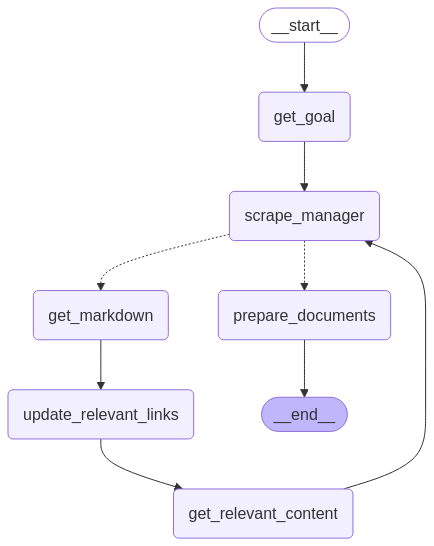

In [5]:
graph_builder.add_node("get_goal", get_goal)
graph_builder.add_node("scrape_manager", scrape_manager)
graph_builder.add_node("get_markdown", get_markdown) 
graph_builder.add_node("get_relevant_content", get_relevant_content)
graph_builder.add_node("update_relevant_links", update_relevant_links)
graph_builder.add_node("prepare_documents", prepare_documents)

graph_builder.add_edge(START, "get_goal")
graph_builder.add_edge("get_goal", "scrape_manager")
graph_builder.add_conditional_edges("scrape_manager", next_url_condition)
graph_builder.add_edge("get_markdown", "update_relevant_links")
graph_builder.add_edge("update_relevant_links", "get_relevant_content")
graph_builder.add_edge("get_relevant_content", "scrape_manager")
graph_builder.add_edge("prepare_documents", END)

graph = graph_builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
# input_string = """python
# instructions = "We're making a chatbot to answer questions related to below user."
# documents = client.scrape("https://github.com/achalaspandit")"""
input_string = """python
  instructions = "We're making a chatbot for the HR in Riverside."
  documents = client.scrape("https://riversideca.gov/")"""

# Create the initial state
initial_state: State = {
    "input": input_string,
    "goal": "",
    "links": set(),
    "vis_links": set(),
    "rel_content":[],
    "next_url": "",
    "content": "",
    "cntr": 0
}

final_state = graph.invoke(initial_state)

print(final_state)

C:\Users\achpi\AppData\Local\Temp\ipykernel_13852\2632278499.py:73: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embedding = OpenAIEmbeddings(model="text-embedding-3-small")


{'input': 'python\n  instructions = "We\'re making a chatbot for the HR in Riverside."\n  documents = client.scrape("https://riversideca.gov/")', 'goal': 'Goal: Creating a chatbot for the HR in Riverside', 'links': {'https://riversideca.gov/council', 'https://www.riversideca.gov/cityclerk/contact-info', 'https://www.riversideca.gov/gov-whotocall.asp', 'https://www.riversideca.gov/cityclerk', 'https://www.riversideca.gov/about-riverside', 'https://www.riversideca.gov/transparency', 'https://www.governmentjobs.com/careers/cityofriversideca', 'https://www.riversideca.gov/government', 'https://www.riversideca.gov/citymanager', 'https://www.riversideca.gov/services', 'https://www.riversideca.gov/media', 'https://www.riversideca.gov/residents', 'https://riversideca.gov/services', 'https://riversideca.gov/jobs', 'https://riversideca.gov/government', 'https://riversideca.gov/human/', 'https://riversideca.gov/calendar', 'https://www.riversideca.gov/mayor', 'https://riversideca.legistar.com/Cale

In [7]:
final_state["rel_content"]

['Title: Riverside, California | City of Arts & Innovation\nURL Source: \nMarkdown Content:\nRiverside, California | City of Arts & Innovation\n===============    \n(\nPAGE MENU X\nSearch\n \n#### Main Menu Links\n*   ( "/")\n*   (\n*   (\n*   (\n*   (\n*   (\n*   (\n*   ( "Riverside City Jobs")\n*   (\n*   (\n*   (\n*   (\n  \n#### City Links\n*   ( "City of Riverside Home Page")\n*   (\n*   ( "Shop Riverside")\n*   ( "RPU Website")\n*   ( "City of Riverside Home Page")\n*   (\n*   ( "Shop Riverside")\n*   ( "RPU Website")\n!( Language!( 8](\nSearch\n \nriversideca.gov\n \n( "/")\n\xa0\xa0( | \xa0\xa0( | ( 10: Riverside Alert Logo](\nToggle offcanvas navigation\n*   (\n*   (\n*   (\n*   (\n*   (\n*   (\n*   (\n*   ( "Riverside City Jobs")\n*   ( "City of Riverside Home Page")\n*   (\n*   ( "Shop Riverside")\n*   ( "RPU Website")\n  \n(\n(\n(\n(\n( Non-Emergency]( Awards]( Opportunities]( Meetings]( Your Utility Bill]( Outages](\nWhat\'s Happening in Riverside\n========================